In [136]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/FinalPipeline')
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import StellarConfig as strConfig
import Config
# from matplotlib.path import Path Cut has already been applied
matplotlib.style.use('des_dr1')
import scipy as sc

In [110]:
directory = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/FinalPipeline/Tests/Object_Counts/'

numAreas = 3
rMagCut = [23.9, 24.5]

persUsed = [0.0, 5, 10, 15, 20, 40, 60, 80, 100]

In [111]:
starResults = []
galaResults = []

for i in persUsed:
    starReadFile = directory + 'Stars/Three_Area_Errors/' + str(i) + '_Percent_' + str(rMagCut[0]) + '_' + str(rMagCut[1]) + '.fits'
    starResults.append(fitsio.read(starReadFile))
    galaReadFile = directory + 'Galaxies/Three_Area_Errors/' + str(i) + '_Percent_' + str(rMagCut[0]) + '_' + str(rMagCut[1]) + '.fits'
    galaResults.append(fitsio.read(galaReadFile))

In [112]:
persUsed = np.array(persUsed)

In [113]:
starPlots = []
galaPlots = []

for i in np.arange(numAreas):
    indStarPlot = []
    indGalaPlot = []
    for j in np.arange(len(persUsed)):
        indStarPlot.append(np.average(starResults[j][str(i)]))
        indGalaPlot.append(np.average(galaResults[j][str(i)]))
    indStarPlot = np.array(indStarPlot)
    indGalaPlot = np.array(indGalaPlot)
    starPlots.append(indStarPlot)
    galaPlots.append(indGalaPlot)
    
starPlots = np.array(starPlots)
galaPlots = np.array(galaPlots)

In [114]:
def exp(x, C, k, b):
    return (C*np.exp(-1 * k * x) + b)

In [172]:
plotMax = np.max(galaPlots, axis = 0)[1:] - 1
plotMin = np.min(galaPlots, axis = 0)[1:] - 1

In [173]:
useIndsMax = []
useIndsMin = []
for i in range(len(plotMax) - 1):
    if plotMax[i] > plotMax[i + 1]:
        useIndsMax.append(i)
    if plotMin[i] < plotMin[i + 1]:
        useIndsMin.append(i)
useIndsMax.append(len(plotMax) - 1)
useIndsMin.append(len(plotMax) - 1)

In [174]:
poptMax, pcov = sc.optimize.curve_fit(exp, persUsed[1:][useIndsMax], plotMax[useIndsMax], bounds=([-0.5, 0., 0.], [0.5, 0.2, 0.1]))
poptMin, pcov = sc.optimize.curve_fit(exp, persUsed[1:][useIndsMin], plotMin[useIndsMin], bounds=([-0.5, 0., -0.1], [0., 0.2, 0.]))

In [176]:
print(poptMax)
print(poptMin)

[0.33657248 0.15292522 0.01328003]
[-0.24949589  0.12145374 -0.02009841]


In [167]:
-1 * exp(100, *poptMin)

0.01730549929179598

In [169]:
# cmap = plt.get_cmap("tab10")
# plt.figure(dpi = 120)
# for i in np.arange(numAreas):
#     for j in np.arange(len(persUsed)):
#         plt.errorbar(np.average(starResults[j][str(i)]), persUsed[j] + (i - 1) * 2, xerr = np.std(starResults[j][str(i)]), color = cmap(i), capsize = 5, fmt = 'o', ms = 3.)
# plt.xlabel(r'$N/\langle N\rangle$ in Area Bin')
# plt.ylabel('Percent of Training Subset Used')
# plt.title('Stars Detected as Stars Relative Detection Rates')
# plt.show()

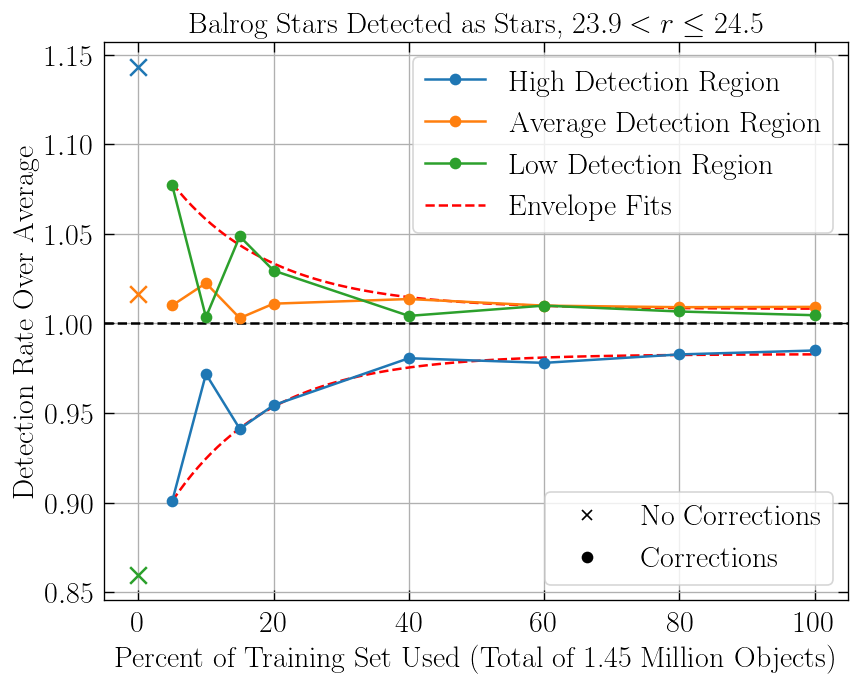

In [170]:
cmap = plt.get_cmap("tab10")

plt.figure(dpi = 120)

plt.scatter(persUsed[0], starPlots[0][0], marker = 'x', s = 100, zorder = 4, color = cmap(0))
line0, = plt.plot(persUsed[1:], starPlots[0][1:], marker = 'o', zorder = 4, color = cmap(0), label = 'High Detection Region')

plt.scatter(persUsed[0], starPlots[1][0], marker = 'x', s = 100, zorder = 4, color = cmap(1))
line1, = plt.plot(persUsed[1:], starPlots[1][1:], marker = 'o', zorder = 4, color = cmap(1), label = 'Average Detection Region')

plt.scatter(persUsed[0], starPlots[2][0], marker = 'x', s = 100, zorder = 4, color = cmap(2))
line2, = plt.plot(persUsed[1:], starPlots[2][1:], marker = 'o', zorder = 4, color = cmap(2), label = 'Low Detection Region')

plt.plot(np.linspace(persUsed[1], 100, 100), exp(np.linspace(persUsed[1], 100, 100), *poptMax) + 1, color = 'r', linestyle = '--')
lineEnv, = plt.plot(np.linspace(persUsed[1], 100, 100), exp(np.linspace(persUsed[1], 100, 100), *poptMin) + 1, color = 'r', linestyle = '--', label = 'Envelope Fits')

first_legend = plt.legend(handles=[line0, line1, line2, lineEnv], loc='upper right')
plt.gca().add_artist(first_legend)

plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
plt.grid(zorder = 0)
plt.legend()
plt.ylabel('Detection Rate Over Average')
plt.xlabel('Percent of Training Set Used (Total of 1.45 Million Objects)')
plt.title(r'Balrog Stars Detected as Stars, $23.9<r\leq 24.5$')

handles = [mlines.Line2D([], [], marker=marker, mec='k', mfc='k', ls='') for marker in ['x', 'o']]
plt.legend(handles, ['No Corrections', 'Corrections'], loc='lower right')

# plt.text(62.5, 0.88, r'$y = Ce^{-kx} + b$' '\n' r'$C = -0.116$' '\n' r'$k = 0.068$' '\n' r'$b = 0.983$', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, zorder = 3)
plt.show()

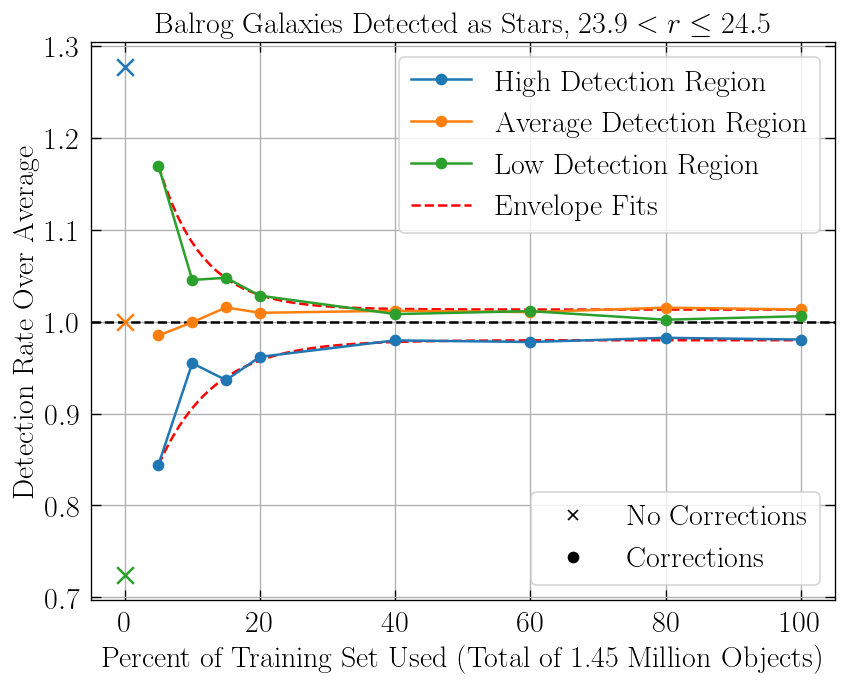

In [162]:
cmap = plt.get_cmap("tab10")

plt.figure(dpi = 120)

plt.scatter(persUsed[0], galaPlots[0][0], marker = 'x', s = 100, zorder = 4, color = cmap(0))
line0, = plt.plot(persUsed[1:], galaPlots[0][1:], marker = 'o', zorder = 4, color = cmap(0), label = 'High Detection Region')

plt.scatter(persUsed[0], galaPlots[1][0], marker = 'x', s = 100, zorder = 4, color = cmap(1))
line1, = plt.plot(persUsed[1:], galaPlots[1][1:], marker = 'o', zorder = 4, color = cmap(1), label = 'Average Detection Region')

plt.scatter(persUsed[0], galaPlots[2][0], marker = 'x', s = 100, zorder = 4, color = cmap(2))
line2, = plt.plot(persUsed[1:], galaPlots[2][1:], marker = 'o', zorder = 4, color = cmap(2), label = 'Low Detection Region')

plt.plot(np.linspace(persUsed[1], 100, 100), exp(np.linspace(persUsed[1], 100, 100), *poptMax) + 1, color = 'r', linestyle = '--')
lineEnv, = plt.plot(np.linspace(persUsed[1], 100, 100), exp(np.linspace(persUsed[1], 100, 100), *poptMin) + 1, color = 'r', linestyle = '--', label = 'Envelope Fits')

first_legend = plt.legend(handles=[line0, line1, line2, lineEnv], loc='upper right')
plt.gca().add_artist(first_legend)

plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
plt.grid(zorder = 0)
plt.legend()
plt.ylabel('Detection Rate Over Average')
plt.xlabel('Percent of Training Set Used (Total of 1.45 Million Objects)')
plt.title(r'Balrog Galaxies Detected as Stars, $23.9<r\leq 24.5$')

handles = [mlines.Line2D([], [], marker=marker, mec='k', mfc='k', ls='') for marker in ['x', 'o']]
plt.legend(handles, ['No Corrections', 'Corrections'], loc='lower right')

# plt.text(62.5, 0.88, r'$y = Ce^{-kx} + b$' '\n' r'$C = -0.116$' '\n' r'$k = 0.068$' '\n' r'$b = 0.983$', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, zorder = 3)
plt.show()

## Ten Area Bins

In [4]:
origStarAves = []
origStarStds = []
corrStarAves = []
corrStarStds = []

origGalaAves = []
origGalaStds = []
corrGalaAves = []
corrGalaStds = []

for i in np.arange(numAreas):
    origStarAves.append(np.average(starResults[0][str(i)]))
    origStarStds.append(np.std(starResults[0][str(i)]))
    corrStarAves.append(np.average(starResults[-1][str(i)]))
    corrStarStds.append(np.std(starResults[-1][str(i)]))
    
    origGalaAves.append(np.average(galaResults[0][str(i)]))
    origGalaStds.append(np.std(galaResults[0][str(i)]))
    corrGalaAves.append(np.average(galaResults[-1][str(i)]))
    corrGalaStds.append(np.std(galaResults[-1][str(i)]))
    
origStarAves = np.array(origStarAves)
origStarStds = np.array(origStarStds)
corrStarAves = np.array(corrStarAves)
corrStarStds = np.array(corrStarStds)
origGalaAves = np.array(origGalaAves)
origGalaStds = np.array(origGalaStds)
corrGalaAves = np.array(corrGalaAves)
corrGalaStds = np.array(corrGalaStds)

In [5]:
percentiles = np.linspace(10, 1, 10)

In [6]:
print(np.max(np.abs(origGalaAves - 1)))
print(np.max(np.abs(corrGalaAves - 1)))

0.4386266354964111
0.04062080801993073


In [7]:
print(np.std(origGalaAves))
print(np.std(corrGalaAves))

0.24693087448762752
0.024055762742731534


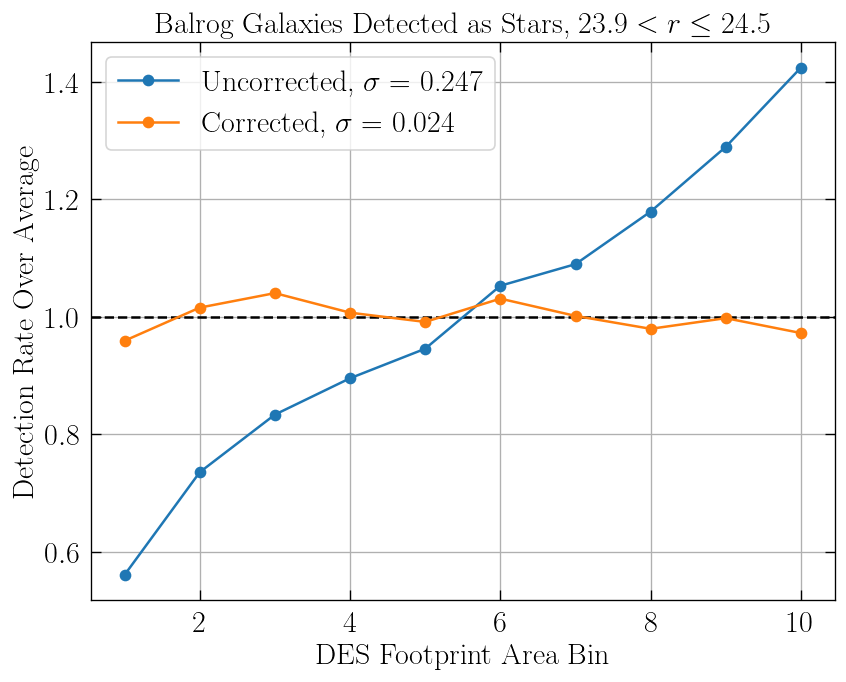

In [8]:
plt.figure(dpi = 120)
plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
# plt.errorbar(percentiles, origGalaAves, yerr = origGalaStds, capsize = 5, fmt = 'o-', ms = 4., label = 'Uncorrected')
# plt.errorbar(percentiles, corrGalaAves, yerr = corrGalaStds, capsize = 5, fmt = 'o-', ms = 4., label = 'Corrected')
plt.plot(percentiles, origGalaAves, label = r'Uncorrected, $\sigma$ = ' + "{:.3f}".format(np.std(origGalaAves)), marker = 'o', zorder = 4)
plt.plot(percentiles, corrGalaAves, label = r'Corrected, $\sigma$ = ' + "{:.3f}".format(np.std(corrGalaAves)), marker = 'o', zorder = 4)
plt.grid(zorder = 0)
plt.legend()
plt.xlabel('DES Footprint Area Bin')
plt.ylabel('Detection Rate Over Average')
plt.title(r'Balrog Galaxies Detected as Stars, $23.9<r\leq 24.5$')
plt.show()

In [13]:
print(np.max(np.abs(origStarAves - 1)))
print(np.max(np.abs(corrStarAves - 1)))

0.23172706819615374
0.03123504667437893


In [14]:
print(np.std(origStarAves))
print(np.std(corrStarAves))

0.1254688581890917
0.018627738654621827


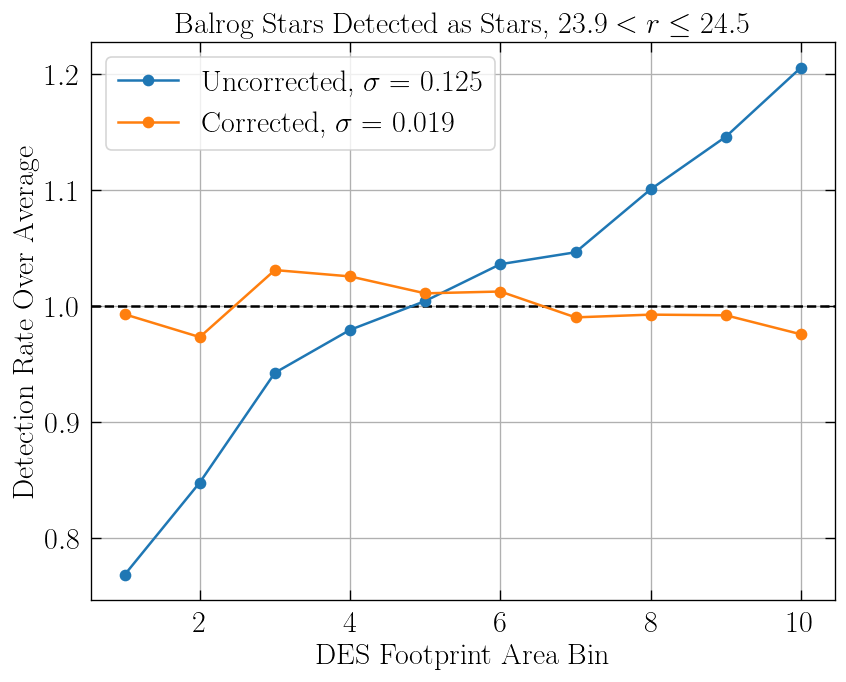

In [15]:
plt.figure(dpi = 120)
plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
# plt.errorbar(percentiles, origStarAves, yerr = origStarStds, capsize = 5, fmt = 'o-', ms = 4., label = 'Uncorrected')
# plt.errorbar(percentiles, corrStarAves, yerr = corrStarStds, capsize = 5, fmt = 'o-', ms = 4., label = 'Corrected')
plt.plot(percentiles, origStarAves, label = r'Uncorrected, $\sigma$ = ' + "{:.3f}".format(np.std(origStarAves)), marker = 'o', zorder = 4)
plt.plot(percentiles, corrStarAves, label = r'Corrected, $\sigma$ = ' + "{:.3f}".format(np.std(corrStarAves)), marker = 'o', zorder = 4)
plt.grid(zorder = 0)
plt.legend()
plt.xlabel('DES Footprint Area Bin')
plt.ylabel('Detection Rate Over Average')
plt.title(r'Balrog Stars Detected as Stars, $23.9<r\leq 24.5$')
plt.show()